# Ziqi Zhang - 1001374684
# Assignment 5

# From Assignment 4

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Let's first get the imports out of the way.

In [0]:
import array
import gzip
import itertools
import numpy
import numpy.random as npr
import os
import struct
import time
from os import path
import urllib.request

import jax.numpy as np
from jax.api import jit, grad
from jax.config import config
from jax.scipy.special import logsumexp
from jax import random

The following cell contains boilerplate code to download and load MNIST data.

In [0]:
_DATA = "/tmp/"

def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return numpy.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=numpy.float32):
  """Create a one-hot encoding of x of size k."""
  return numpy.array(x[:, None] == numpy.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return numpy.array(array.array("B", fh.read()), dtype=numpy.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return numpy.array(array.array("B", fh.read()),
                      dtype=numpy.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(create_outliers=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / numpy.float32(255.)
  test_images = _partial_flatten(test_images) / numpy.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if create_outliers:
    mum_outliers = 30000
    perm = numpy.random.RandomState(0).permutation(mum_outliers)
    train_images[:mum_outliers] = train_images[:mum_outliers][perm]

  return train_images, train_labels, test_images, test_labels

def shape_as_image(images, labels, dummy_dim=False):
  target_shape = (-1, 1, 28, 28, 1) if dummy_dim else (-1, 28, 28, 1)
  return np.reshape(images, target_shape), labels

train_images, train_labels, test_images, test_labels = mnist(create_outliers=False)
num_train = train_images.shape[0]

downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/


The following cell defines the accuracy of our model and how to initialize its parameters. 

In [0]:
def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class)

def init_random_params(layer_sizes, rng=npr.RandomState(0)):
  scale = 0.1
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

The following cell creates a Python generator for our dataset. It outputs one batch of $n$ training examples at a time. 

In [0]:
batch_size = 128
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]
batches = data_stream()

This is now the proper training loop for our fully-connected neural network. 

Before we get started, we need to import two small libraries that contain boilerplate code for common neural network layer types and for optimizers like mini-batch SGD.

In [0]:
from jax.experimental import optimizers
from jax.experimental import stax
import matplotlib.pyplot as plt

Here is a fully-connected neural network architecture, like the one of Problem 1, but this time defined with `stax`

In [0]:
init_random_params, predict = stax.serial(
    stax.Conv(512, (8, 8), padding='SAME', strides=(2, 2)),
    stax.Relu,
    stax.MaxPool((2, 2)),
    stax.Conv(64, (4, 4), padding='VALID', strides=(2, 2)),
    stax.Relu,
    stax.MaxPool((2, 2)),
    stax.Flatten,
    stax.Dense(32),
    stax.Relu,
    stax.Dense(10),
)

We redefine the cross-entropy loss for this model. As done in Problem 1, complete the return line below (it's identical). 

In [0]:
def loss(params, batch):
  inputs, targets = batch
  logits = predict(params, inputs)
  preds  = stax.logsoftmax(logits)
  return -np.mean(np.sum(targets*preds, axis=1))

Next, we define the mini-batch SGD optimizer, this time with the optimizers library in JAX. 

In [0]:
learning_rate = 0.1
opt_init, opt_update, get_params = optimizers.sgd(learning_rate)

@jit
def update(_, i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

The next cell contains our training loop, very similar to Problem 1. 

In [0]:
num_epochs = 11

key = random.PRNGKey(123)
_, init_params = init_random_params(key, (-1, 28, 28, 1))
opt_state = opt_init(init_params)
itercount = itertools.count()

for epoch in range(1, num_epochs + 1):
  for _ in range(num_batches):
    opt_state = update(key, next(itercount), opt_state, shape_as_image(*next(batches)))

  params = get_params(opt_state)
  test_acc = accuracy(params, shape_as_image(test_images, test_labels))
  test_loss = loss(params, shape_as_image(test_images, test_labels))
  print('Test set loss, accuracy (%): ({:.2f}, {:.2f})'.format(test_loss, 100 * test_acc))

Test set loss, accuracy (%): (0.07, 97.78)
Test set loss, accuracy (%): (0.04, 98.57)
Test set loss, accuracy (%): (0.04, 98.87)
Test set loss, accuracy (%): (0.03, 98.91)
Test set loss, accuracy (%): (0.03, 99.07)
Test set loss, accuracy (%): (0.03, 99.05)
Test set loss, accuracy (%): (0.02, 99.26)
Test set loss, accuracy (%): (0.02, 99.17)
Test set loss, accuracy (%): (0.04, 98.78)
Test set loss, accuracy (%): (0.02, 99.19)
Test set loss, accuracy (%): (0.03, 98.88)


# Assignment 5


# Problem 1

We choose the first image to be transformed

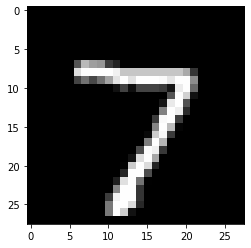

In [0]:
img = test_images[0].reshape(28,28)
plt.imshow(img, cmap="gray")

Perturb image

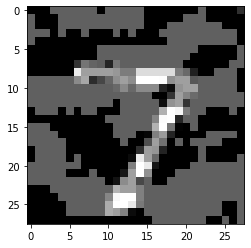

In [0]:
pert_img = img + 0.3 * np.sign((grad(loss,1)(params, shape_as_image(test_images[0], test_labels[0])))[0][0,:,:,0])
plt.imshow(pert_img, cmap="gray")

The neural network misclassified the image as 3

In [0]:
image, label = shape_as_image(pert_img, test_labels[0])
print('Prediction:', np.argmax(predict(params,image)))
print('Prediction Matrix: ', predict(params,image))

Prediction: 3
Prediction Matrix:  [[ -6.5814395  -4.259147   -1.0237657  10.607419   -3.839279    2.144324
  -12.067197    1.8997463   4.541486   10.3046665]]


# Problem 2

Choose the first 1000 images in the MNIST dataset. Test ε for [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1]

In [0]:
from matplotlib.pyplot import figure

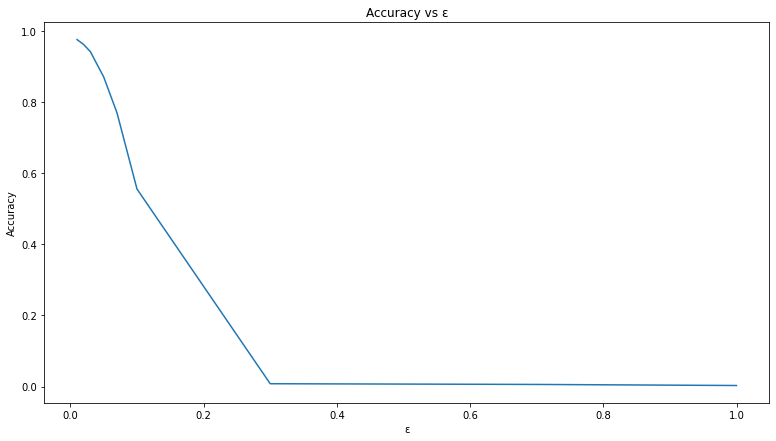

In [0]:
img_set = test_images[0:1000].reshape(1000,28,28)
target_set = test_labels[0:1000]
accuracy_epsl = []
epsl_set = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1]
for epsl in epsl_set:
  pert_img_set = img_set + epsl * np.sign((grad(loss,1)(params, shape_as_image(img_set, target_set)))[0][:,:,:,0])
  test_acc = accuracy(params, shape_as_image(pert_img_set, target_set))
  accuracy_epsl.append(test_acc)

plt.figure(figsize=(13,7))
plt.plot(epsl_set, accuracy_epsl)
plt.title("Accuracy vs ε")
plt.xlabel("ε")
plt.ylabel("Accuracy")
plt.show()

# Problem 3

The perturbed image is misclassified at the second iteration.

Prediction matrix @ itereation 1: [[ -5.927682    -1.826009    -0.54550487   5.0570035   -5.938745
   -2.1181262  -12.314999    11.001078     1.7181077    5.602157  ]]

Prediction matrix @ itereation 2: [[ -5.679646   -3.1200836  -1.0391263   7.5153556  -5.938224   -1.5849626
  -11.819832    7.5863647   2.8668513   8.053486 ]]

Prediction matrix @ itereation 3: [[ -5.0613403   -4.6333547   -1.0154663    9.406424    -6.2508583
   -0.38084826 -10.803736     4.057193     4.6354604   10.43594   ]]

Prediction matrix @ itereation 4: [[ -5.1362066  -6.525953   -2.1073217  10.434774   -5.832472    1.138476
  -10.908064    1.4775141   5.694885   14.063976 ]]

Prediction matrix @ itereation 5: [[ -5.706774   -9.019482   -4.3671246  10.749833   -5.8275366   2.4585705
  -10.931724   -0.3552324   7.916349   17.585302 ]]



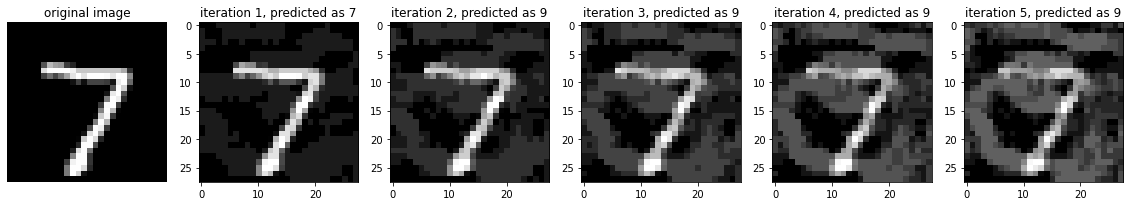

In [0]:
fig = plt.figure(figsize=(20, 10))
fig.tight_layout()
plt.subplot(1, 6, 1)
plt.axis('off')
pert_img = test_images[0].reshape(28,28)
plt.imshow(pert_img, cmap="gray")
plt.title("original image")
k = 5
epsl = 0.3
for i in range (k):
  pert_img = pert_img + epsl/k * np.sign((grad(loss,1)(params, shape_as_image(pert_img, test_labels[0])))[0][0,:,:,0])
  plt.subplot(1, 6, i+2)
  plt.imshow(pert_img, cmap="gray")
  image, label = shape_as_image(pert_img, test_labels[0])
  plt.title ("iteration {}, predicted as {}".format(i+1,np.argmax(predict(params,image))))
  print('Prediction matrix @ itereation {0}: {1}\n'.format(i+1, predict(params,image)))
plt.show()

# Problem 4

The performance improves for the same ε value when the step size is decreased.

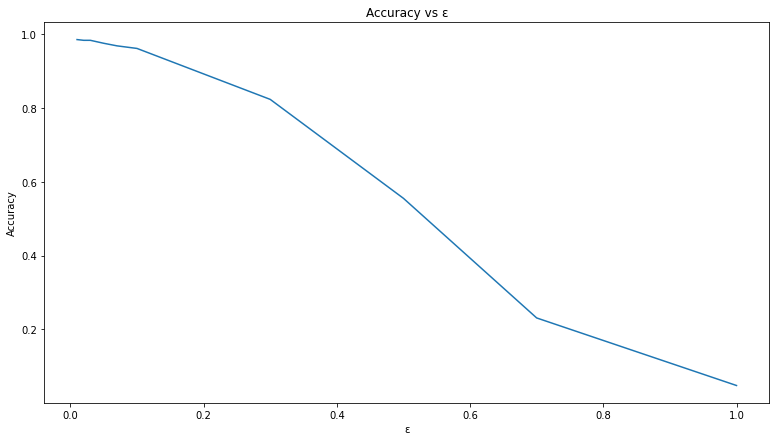

In [0]:
img_set = test_images[0:1000].reshape(1000,28,28)
target_set = test_labels[0:1000]
accuracy_epsl = []
epsl_set = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1]
k = 5
for epsl in epsl_set:
  for i in range(k):
    pert_img_set = img_set + epsl/k * np.sign((grad(loss,1)(params, shape_as_image(img_set, target_set)))[0][:,:,:,0])
  test_acc = accuracy(params, shape_as_image(pert_img_set, target_set))
  accuracy_epsl.append(test_acc)

plt.figure(figsize=(13,7))
plt.plot(epsl_set, accuracy_epsl)
plt.title("Accuracy vs ε")
plt.xlabel("ε")
plt.ylabel("Accuracy")
plt.show()